# Generative Modeling of Stellar Evolution Tracks with GANs

In [1]:
# Cell 1: Import libraries

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
import os
from tqdm import tqdm
import matplotlib.colors
import joblib
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 1. Data Loading and Exploration


In [2]:
# Cell 2: Data loading and exploration

# Load the HYG database
df = pd.read_csv('../hyg_v42.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (119626, 37)

Column names:
['id', 'hip', 'hd', 'hr', 'gl', 'bf', 'proper', 'ra', 'dec', 'dist', 'pmra', 'pmdec', 'rv', 'mag', 'absmag', 'spect', 'ci', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'rarad', 'decrad', 'pmrarad', 'pmdecrad', 'bayer', 'flam', 'con', 'comp', 'comp_primary', 'base', 'lum', 'var', 'var_min', 'var_max']

First few rows:


,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,bayer,flam,con,comp,comp_primary,base,lum,var,var_min,var_max
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,1,0,NaN,1.000000,NaN,NaN,NaN
1,1,1.0,224700.0,NaN,NaN,NaN,NaN,0.000060,1.089009,219.7802,...,NaN,NaN,Psc,1,1,NaN,9.638290,NaN,NaN,NaN
2,2,2.0,224690.0,NaN,NaN,NaN,NaN,0.000283,-19.498840,47.9616,...,NaN,NaN,Cet,1,2,NaN,0.392283,NaN,NaN,NaN
3,3,3.0,224699.0,NaN,NaN,NaN,NaN,0.000335,38.859279,442.4779,...,NaN,NaN,And,1,3,NaN,386.901132,NaN,NaN,NaN
4,4,4.0,224707.0,NaN,NaN,NaN,NaN,0.000569,-51.893546,134.2282,...,NaN,NaN,Phe,1,4,NaN,9.366989,NaN,NaN,NaN


In [3]:
# Cell 3: Check missing values
print("Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

Missing values per column:
proper          119127
base            118540
bayer           118089
flam            116889
bf              116527
gl              115825
var             113634
hr              110585
var_max         102635
var_min         102635
hd               20741
spect             3048
ci                1891
hip               1675
con                  1
pmrarad              0
pmdecrad             0
comp_primary         0
comp                 0
rarad                0
dtype: int64


In [4]:
# Cell 4: Select relevant columns
# Select relevant columns for stellar evolution analysis
relevant_columns = [
    'mag', 'absmag', 'ci', 'spect', 'dist', 'x', 'y', 'z', 
    'lum', 'var', 'var_min', 'var_max'
]

# Create a copy with only relevant columns
df_filtered = df[relevant_columns].copy()

# Display missing values in our filtered dataset
print("Missing values in filtered dataset:")
df_filtered.isnull().sum().sort_values(ascending=False)

Missing values in filtered dataset:


var        113634
var_min    102635
var_max    102635
spect        3048
ci           1891
mag             0
absmag          0
dist            0
x               0
y               0
z               0
lum             0
dtype: int64

In [5]:
# Cell 5: Handle missing values
# Handle missing values strategically
critical_features = ['absmag', 'ci', 'lum', 'dist']
df_critical = df_filtered[critical_features].copy()

print("Missing values after initial imputation:")
print(df_critical.isnull().sum())

# Create a clean dataset without any missing values
df_clean = df_critical.dropna()
print(f"Clean dataset shape: {df_clean.shape}")

Missing values after initial imputation:
absmag       0
ci        1891
lum          0
dist         0
dtype: int64
Clean dataset shape: (117735, 4)


In [6]:
# Cell 6: Basic statistics
# Basic statistics of the filtered dataset
df_filtered.describe()

,mag,absmag,ci,dist,x,y,z,lum,var_min,var_max
count,119626.000000,119626.000000,117735.000000,119626.000000,119626.000000,119626.000000,119626.000000,1.196260e+05,16991.000000,16991.000000
mean,8.429465,0.990741,0.711516,8772.285030,-235.250971,-39.324238,-235.029843,3.565260e+05,9.501549,9.258892
std,1.427752,4.353396,0.493218,27890.666828,15182.707650,17248.951976,18074.563273,3.341375e+06,1.781276,1.742416
min,-26.700000,-16.680000,-0.400000,0.000000,-99950.391271,-99979.246192,-99964.982269,1.225745e-06,-1.333000,-1.523000
25%,7.650000,0.138000,0.348500,115.074800,-89.043152,-91.176368,-107.566739,4.746790e+00,8.525500,8.243000
50%,8.460000,1.495000,0.616000,213.675200,-1.050364,-1.238857,-3.415646,2.197860e+01,9.849000,9.646000
75%,9.170000,3.159000,1.083000,392.156900,86.267843,91.872584,94.974160,7.670082e+01,10.707000,10.492000
max,21.000000,19.629000,5.460000,100000.000000,99982.372691,99996.065513,99862.513669,4.092607e+08,14.902000,13.702000


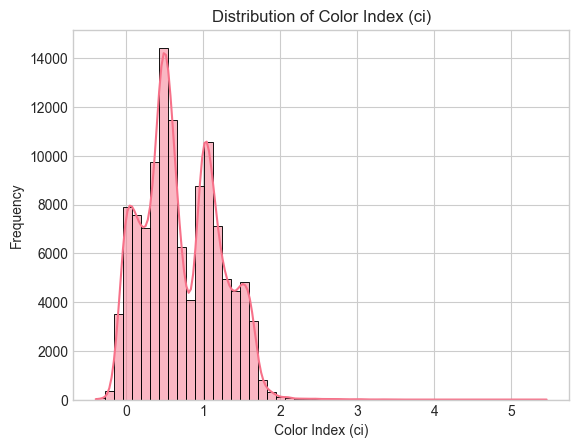

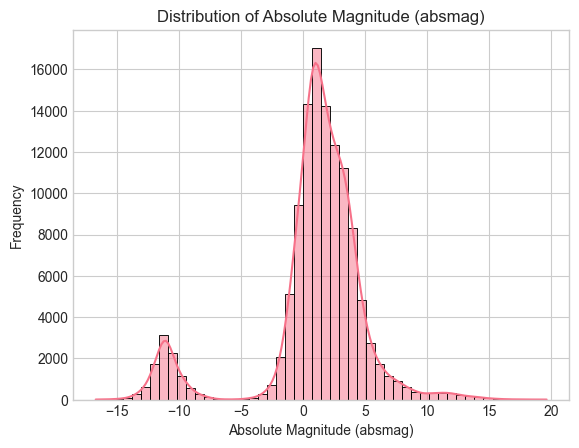

In [7]:
# Cell 7: Distribution plots
# Distribution plots
sns.histplot(df_filtered['ci'].dropna(), bins=50, kde=True)
plt.title('Distribution of Color Index (ci)')
plt.xlabel('Color Index (ci)')
plt.ylabel('Frequency')
plt.show()

sns.histplot(df_filtered['absmag'].dropna(), bins=50, kde=True)
plt.title('Distribution of Absolute Magnitude (absmag)')
plt.xlabel('Absolute Magnitude (absmag)')
plt.ylabel('Frequency')
plt.show()

## 2. Data Preprocessing


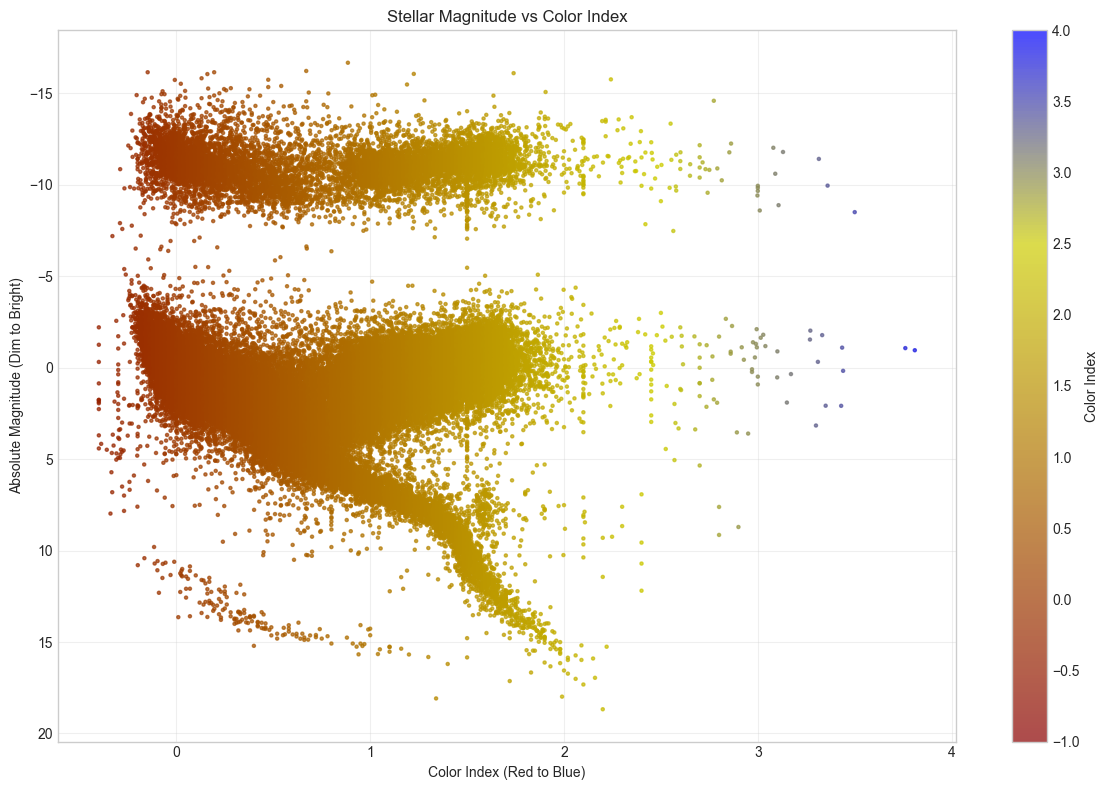

In [8]:
# Cell 8: Data preprocessing and visualization

# Handle missing values for visualization
df_viz = df_filtered.dropna(subset=['ci', 'absmag']).copy()
df_viz = df_viz[(df_viz['ci'] >= -1.0) & (df_viz['ci'] <= 4.0)]

# Create custom colormap
red4 = (139/255, 0, 0)
yellow3 = (205/255, 205/255, 0)
blue = (0, 0, 1)
colors = [red4, yellow3, blue]
positions = [0.0, 0.7, 1.0]
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_r_gradient", list(zip(positions, colors)))

# Create HR diagram plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_viz['ci'], df_viz['absmag'], 
                      c=df_viz['ci'], cmap=custom_cmap, 
                      alpha=0.7, s=5, vmin=-1.0, vmax=4.0)

cbar = plt.colorbar(scatter, label='Color Index')
cbar.set_ticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0])

plt.xlabel('Color Index (Red to Blue)')
plt.ylabel('Absolute Magnitude (Dim to Bright)')
plt.title('Stellar Magnitude vs Color Index')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# Cell 9: Filter outliers and prepare features
# Filter out extreme outliers
df_clean = df_filtered[
    (df_filtered['ci'] > -0.5) & (df_filtered['ci'] < 2.5) &
    (df_filtered['absmag'] > -5) & (df_filtered['absmag'] < 15) &
    (df_filtered['lum'] > 0.001) & (df_filtered['lum'] < 1000000)
].copy()

print(f"Cleaned dataset shape: {df_clean.shape}")

# Apply log transformation to luminosity
df_clean['log_lum'] = np.log10(df_clean['lum'] + 1e-10)

# Select features for the generative model
features = ['ci', 'absmag', 'log_lum', 'dist']
df_features = df_clean[features].dropna()
print(f"Final dataset for modeling: {df_features.shape}")

Cleaned dataset shape: (107368, 12)
Final dataset for modeling: (107368, 4)


In [10]:
# Cell 10: Normalize features
# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(scaled_features, columns=features)
df_scaled.head()

,ci,absmag,log_lum,dist
0,-0.087162,1.315505,-1.315505,-1.308336
1,-0.456446,0.186458,-0.186458,-0.150054
2,0.640795,1.781811,-1.781811,-1.055570
3,-1.519730,-1.653522,1.653522,1.023604
4,-0.694146,0.200686,-0.200686,-0.600929


## 3. Dimensionality Reduction with PCA


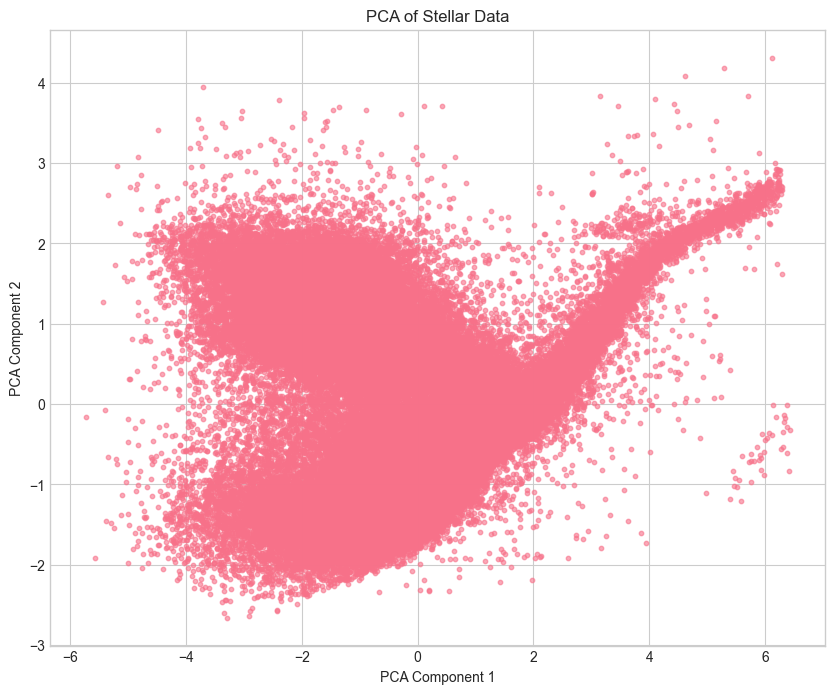

Explained variance ratio: [0.64870165 0.25530201]


In [11]:
# Cell 11: PCA analysis

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6, s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Stellar Data')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

## 4. GAN Implementation


In [21]:
# Cell 12: GAN implementation

class GAN(keras.Model):
    def __init__(self, latent_dim, input_dim,g_lr,d_lr):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        
        # Generator
        self.generator = keras.Sequential([
            layers.Dense(128, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(input_dim, activation='linear')
        ])
        
        # Discriminator
        self.discriminator = keras.Sequential([
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        
        self.g_optimizer = keras.optimizers.Adam(learning_rate=g_lr, beta_1=0.5)
        self.d_optimizer = keras.optimizers.Adam(learning_rate=d_lr, beta_1=0.5)
        self.loss_fn = keras.losses.BinaryCrossentropy()
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
    
    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        
        # Train Discriminator
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_data = self.generator(noise, training=True)
        
        real_labels = tf.ones((batch_size, 1)) * 0.9  # Label smoothing
        fake_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as d_tape:
            real_predictions = self.discriminator(real_data, training=True)
            fake_predictions = self.discriminator(generated_data, training=True)
            
            d_real_loss = self.loss_fn(real_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_labels, fake_predictions)
            d_loss = d_real_loss + d_fake_loss
        
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
        # Train Generator
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        with tf.GradientTape() as g_tape:
            generated_data = self.generator(noise, training=True)
            predictions = self.discriminator(generated_data, training=True)
            g_loss = self.loss_fn(real_labels, predictions)  # Trick discriminator
        
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss}

In [22]:
# Cell 13: Prepare training data
# Prepare training data
X_train = df_scaled.values.astype(np.float32)

# Initialize GAN
latent_dim = 100  # Larger latent space for GANs
input_dim = X_train.shape[1]

gan = GAN(latent_dim, input_dim,g_lr=0.001,d_lr=0.001)
gan.compile(
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5),
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)

In [23]:
# Cell 14: Training loop with callbacks
# Training parameters
epochs = 100
batch_size = 32

# Custom learning rate scheduler for GAN
class GANLRScheduler:
    def __init__(self, g_optimizer, d_optimizer, factor=0.5, patience=20, min_lr=1e-6):
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_g_loss = float('inf')
        self.best_d_loss = float('inf')
        self.wait = 0
        self.g_lr_history = []
        self.d_lr_history = []
        
    def on_epoch_end(self, epoch, g_loss, d_loss):
        current_g_lr = float(self.g_optimizer.learning_rate.numpy())
        current_d_lr = float(self.d_optimizer.learning_rate.numpy())
        self.g_lr_history.append(current_g_lr)
        self.d_lr_history.append(current_d_lr)
        
        # Use generator loss for scheduling
        if g_loss < self.best_g_loss:
            self.best_g_loss = g_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_g_lr = max(current_g_lr * self.factor, self.min_lr)
                
                if new_g_lr < current_g_lr:
                    self.g_optimizer.learning_rate.assign(new_g_lr)
                    print(f"Reducing learning rates to G: {new_g_lr:.2e}")
                    self.wait = 0

        # Use discriminator loss for scheduling
        if d_loss < self.best_d_loss:
            self.best_d_loss = d_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_d_lr = max(current_d_lr * self.factor, self.min_lr)
                
                if new_d_lr < current_d_lr:
                    self.d_optimizer.learning_rate.assign(new_d_lr)
                    print(f"Reducing learning rates to D: {new_d_lr:.2e}")
                    self.wait = 0
        

# Custom early stopping for GAN
class GANEarlyStopping:
    def __init__(self, patience=50, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_g_loss = float('inf')
        self.wait = 0
        self.stopped_epoch = 0
        self.best_g_weights = None
        self.best_d_weights = None
        
    def on_epoch_end(self, epoch, g_loss, d_loss, generator, discriminator):
        if g_loss < self.best_g_loss - self.min_delta:
            self.best_g_loss = g_loss
            self.wait = 0
            self.best_g_weights = generator.get_weights()
            self.best_d_weights = discriminator.get_weights()
        else:
            self.wait += 1
            
        if self.wait >= self.patience:
            self.stopped_epoch = epoch
            if self.best_g_weights is not None and self.best_d_weights is not None:
                generator.set_weights(self.best_g_weights)
                discriminator.set_weights(self.best_d_weights)
            return True
        return False

# Initialize callbacks
lr_scheduler = GANLRScheduler(gan.g_optimizer, gan.d_optimizer, factor=0.5, patience=5, min_lr=1e-6)
early_stopping = GANEarlyStopping(patience=10, min_delta=0.01)

# Training loop
d_losses = []
g_losses = []
best_g_loss = float('inf')
best_d_loss = float('inf')
best_g_weights = None
best_d_weights = None

# Create checkpoint directory
os.makedirs('model_checkpoints', exist_ok=True)

for epoch in range(epochs):
    # Shuffle data
    idx = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[idx]
    
    epoch_d_loss = 0
    epoch_g_loss = 0
    num_batches = 0
    
    for i in tqdm(range(0, len(X_train_shuffled), batch_size), desc=f"Epoch {epoch+1}/{epochs}"):
        batch = X_train_shuffled[i:i + batch_size]
        if len(batch) < batch_size:
            continue
            
        losses = gan.train_step(batch)
        epoch_d_loss += losses["d_loss"].numpy()
        epoch_g_loss += losses["g_loss"].numpy()
        num_batches += 1
    
    if num_batches > 0:
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
    
    # Update learning rate
    lr_scheduler.on_epoch_end(epoch, avg_g_loss, avg_d_loss)
    
    # Save best generator weights
    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        best_g_weights = gan.generator.get_weights()
        gan.generator.save_weights('model_checkpoints/best_generator.weights.h5')
        print(f"New best generator weights saved with loss: {best_g_loss:.4f}")
    
    # Save best discriminator weights
    if avg_d_loss < best_d_loss:
        best_d_loss = avg_d_loss
        best_d_weights = gan.discriminator.get_weights()
        gan.discriminator.save_weights('model_checkpoints/best_discriminator.weights.h5')
        print(f"New best discriminator weights saved with loss: {best_d_loss:.4f}")
    
    # Save checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        gan.generator.save_weights(f'model_checkpoints/generator_epoch_{epoch+1:03d}.weights.h5')
        gan.discriminator.save_weights(f'model_checkpoints/discriminator_epoch_{epoch+1:03d}.weights.h5')
        print(f"Checkpoint saved at epoch {epoch+1}")
    
    # Check for early stopping
    if early_stopping.on_epoch_end(epoch, avg_g_loss, avg_d_loss, gan.generator, gan.discriminator):
        print(f"Early stopping triggered at epoch {epoch}")
        break
    
    current_g_lr = float(gan.g_optimizer.learning_rate.numpy())
    current_d_lr = float(gan.d_optimizer.learning_rate.numpy())
    print(f"Epoch {epoch}, D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, "
          f"G LR: {current_g_lr:.6f}, D LR: {current_d_lr:.6f}")

print("Training completed!")

# Load the best weights from training
if best_g_weights is not None:
    gan.generator.set_weights(best_g_weights)
    print("Loaded best generator weights")
if best_d_weights is not None:
    gan.discriminator.set_weights(best_d_weights)
    print("Loaded best discriminator weights")

# If early stopping was triggered, we might have even better weights
if early_stopping.stopped_epoch > 0:
    print(f"Training stopped early at epoch {early_stopping.stopped_epoch}")
    if early_stopping.best_g_weights is not None:
        gan.generator.set_weights(early_stopping.best_g_weights)
        print("Loaded best generator weights from early stopping")
    if early_stopping.best_d_weights is not None:
        gan.discriminator.set_weights(early_stopping.best_d_weights)
        print("Loaded best discriminator weights from early stopping")

Epoch 1/100: 100%|██████████| 3356/3356 [17:20<00:00,  3.23it/s]


New best generator weights saved with loss: 0.9867
New best discriminator weights saved with loss: 1.2922
Epoch 0, D Loss: 1.2922, G Loss: 0.9867, G LR: 0.001000, D LR: 0.001000


Epoch 2/100: 100%|██████████| 3356/3356 [22:29<00:00,  2.49it/s]


New best generator weights saved with loss: 0.7803
Epoch 1, D Loss: 1.3764, G Loss: 0.7803, G LR: 0.001000, D LR: 0.001000


Epoch 3/100: 100%|██████████| 3356/3356 [21:00<00:00,  2.66it/s]


Epoch 2, D Loss: 1.3764, G Loss: 0.7821, G LR: 0.001000, D LR: 0.001000


Epoch 4/100: 100%|██████████| 3356/3356 [15:54<00:00,  3.52it/s]


Reducing learning rates to D: 5.00e-04
Epoch 3, D Loss: 1.3744, G Loss: 0.7881, G LR: 0.001000, D LR: 0.000500


Epoch 5/100: 100%|██████████| 3356/3356 [17:13<00:00,  3.25it/s]


Epoch 4, D Loss: 1.3760, G Loss: 0.7810, G LR: 0.001000, D LR: 0.000500


Epoch 6/100: 100%|██████████| 3356/3356 [18:39<00:00,  3.00it/s]


Epoch 5, D Loss: 1.3756, G Loss: 0.7815, G LR: 0.001000, D LR: 0.000500


Epoch 7/100: 100%|██████████| 3356/3356 [16:30<00:00,  3.39it/s]


Reducing learning rates to G: 5.00e-04
Epoch 6, D Loss: 1.3753, G Loss: 0.7839, G LR: 0.000500, D LR: 0.000500


Epoch 8/100: 100%|██████████| 3356/3356 [16:59<00:00,  3.29it/s]


Epoch 7, D Loss: 1.3751, G Loss: 0.7819, G LR: 0.000500, D LR: 0.000500


Epoch 9/100: 100%|██████████| 3356/3356 [17:34<00:00,  3.18it/s]


New best generator weights saved with loss: 0.7802
Epoch 8, D Loss: 1.3760, G Loss: 0.7802, G LR: 0.000500, D LR: 0.000500


Epoch 10/100: 100%|██████████| 3356/3356 [19:00<00:00,  2.94it/s]


New best generator weights saved with loss: 0.7797
Epoch 9, D Loss: 1.3761, G Loss: 0.7797, G LR: 0.000500, D LR: 0.000500


Epoch 11/100: 100%|██████████| 3356/3356 [18:31<00:00,  3.02it/s]


Epoch 10, D Loss: 1.3761, G Loss: 0.7801, G LR: 0.000500, D LR: 0.000500


Epoch 12/100: 100%|██████████| 3356/3356 [19:22<00:00,  2.89it/s]


New best generator weights saved with loss: 0.7795
Early stopping triggered at epoch 11
Training completed!
Loaded best generator weights
Loaded best discriminator weights
Training stopped early at epoch 11
Loaded best generator weights from early stopping
Loaded best discriminator weights from early stopping


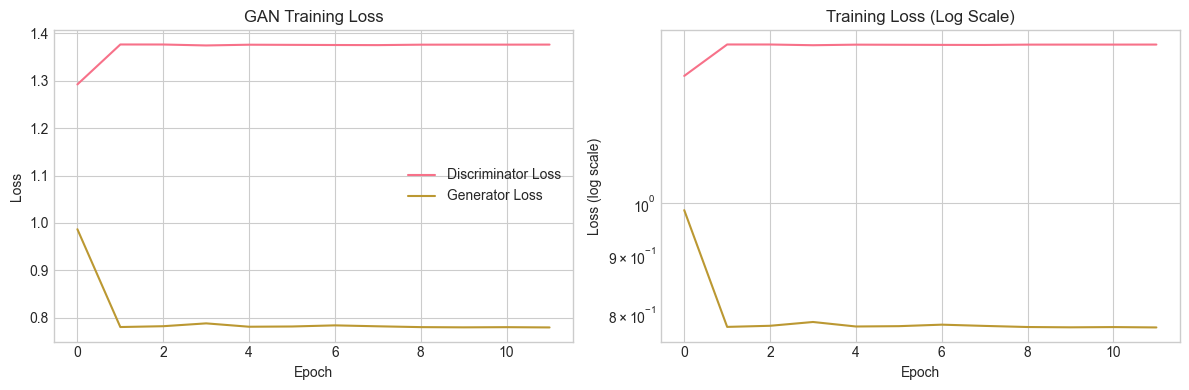

In [24]:
# Cell 15: Plot training history
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Loss')

plt.subplot(1, 2, 2)
plt.plot(d_losses)
plt.plot(g_losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss (Log Scale)')
plt.tight_layout()
plt.show()
#Training Hisotry plots

## 5. Generate Synthetic Stellar Data with GAN


In [25]:
# Cell 16: Generate synthetic data

def generate_samples(n_samples):
    noise = tf.random.normal(shape=(n_samples, latent_dim))
    generated_samples = gan.generator(noise, training=False).numpy()
    generated_original = scaler.inverse_transform(generated_samples)
    return pd.DataFrame(generated_original, columns=features)

# Generate synthetic stars
n_samples = 100000
synthetic_stars = generate_samples(n_samples)

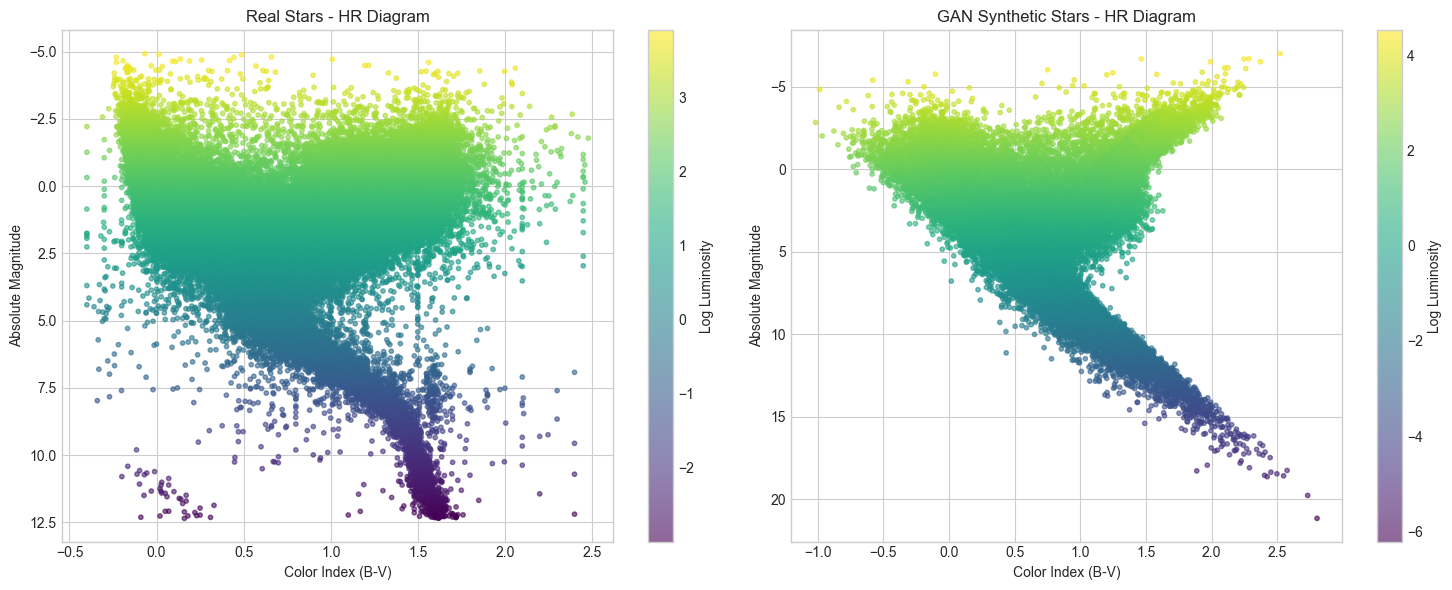

In [ ]:
# Cell 17: Compare real vs synthetic
# Compare real and synthetic data
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_features['ci'], df_features['absmag'], 
            alpha=0.6, s=10, c=df_features['log_lum'], cmap='viridis')
plt.colorbar(label='Log Luminosity')
plt.xlabel('Color Index (B-V)')
plt.ylabel('Absolute Magnitude')
plt.title('Real Stars - HR Diagram')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.scatter(synthetic_stars['ci'], synthetic_stars['absmag'], 
            alpha=0.6, s=10, c=synthetic_stars['log_lum'], cmap='viridis')
plt.colorbar(label='Log Luminosity')
plt.xlabel('Color Index (B-V)')
plt.ylabel('Absolute Magnitude')
plt.title('GAN Synthetic Stars - HR Diagram')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
# Real Stars - HR Diagram vs Synthetic Stars - HR Diagram

## 6. Generate Stellar Evolution Tracks with GAN


In [27]:
# Cell 18: Generate evolution tracks

def generate_evolution_track(initial_z, target_z, steps=50):
    """Generate evolution track by interpolating in latent space"""
    z_path = []
    for i in range(steps):
        alpha = i / (steps - 1)
        z_point = (1 - alpha) * initial_z + alpha * target_z
        z_path.append(z_point)
    
    z_path = np.array(z_path)
    # Remove extra dimension if present
    if z_path.ndim == 3:
        z_path = z_path.squeeze(axis=1)
    
    generated_samples = gan.generator(z_path, training=False).numpy()
    generated_original = scaler.inverse_transform(generated_samples)
    return pd.DataFrame(generated_original, columns=features)

# Select points for evolution - sample from latent space directly
# Since GANs don't have an encoder, we'll find points close to our desired features in latent space
def find_latent_point(target_features, n_samples=1000):
    """Find a latent point that generates features close to target"""
    best_z = None
    best_diff = float('inf')
    
    for _ in range(n_samples):
        z = tf.random.normal(shape=(1, latent_dim))
        generated = gan.generator(z, training=False).numpy()
        generated_original = scaler.inverse_transform(generated)
        
        # Calculate difference from target
        diff = np.sum(np.abs(generated_original - target_features))
        
        if diff < best_diff:
            best_diff = diff
            best_z = z.numpy()
    
    return best_z

# Target features for different stellar types
main_sequence_target = np.array([[0.5, 5.0, np.log10(1.0), 100.0]])  # ci, absmag, log_lum, dist
red_giant_target = np.array([[1.2, -0.5, np.log10(100.0), 100.0]])
white_dwarf_target = np.array([[0.0, 11.0, np.log10(0.01), 100.0]])

# Find corresponding latent points
main_sequence_z = find_latent_point(main_sequence_target)
red_giant_z = find_latent_point(red_giant_target)
white_dwarf_z = find_latent_point(white_dwarf_target)

# Generate evolution tracks
ms_to_giant_track = generate_evolution_track(main_sequence_z, red_giant_z, steps=10000)
giant_to_wd_track = generate_evolution_track(red_giant_z, white_dwarf_z, steps=10000)

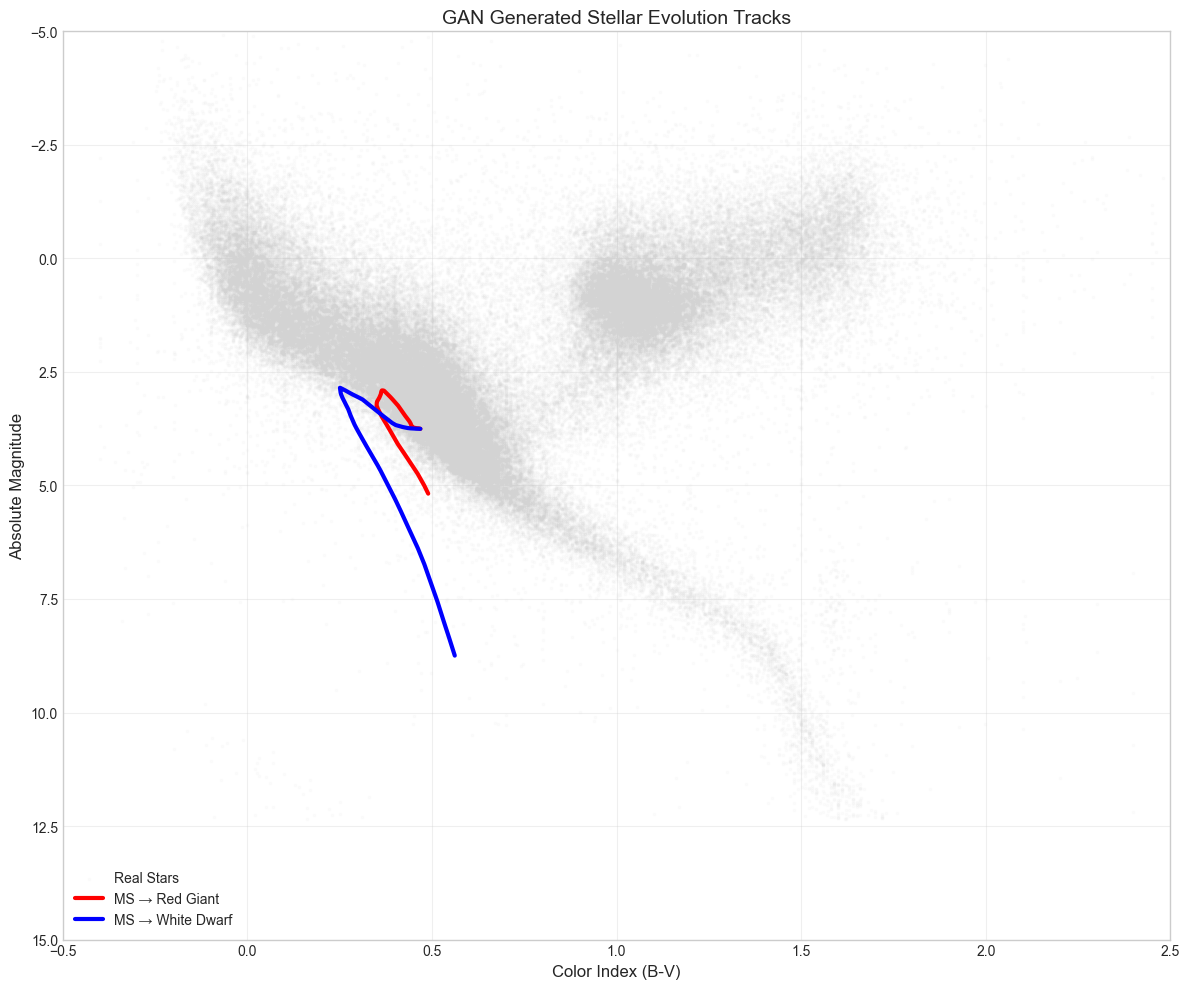

In [28]:
# Cell 19: Plot evolution tracks
# Plot evolution tracks
plt.figure(figsize=(12, 10))
plt.scatter(df_features['ci'], df_features['absmag'], alpha=0.05, s=3, c='lightgray', label='Real Stars')
plt.plot(ms_to_giant_track['ci'], ms_to_giant_track['absmag'], '-', linewidth=3, color='red', label='MS → Red Giant')
plt.plot(giant_to_wd_track['ci'], giant_to_wd_track['absmag'], '-', linewidth=3, color='blue', label='MS → White Dwarf')

plt.xlabel('Color Index (B-V)', fontsize=12)
plt.ylabel('Absolute Magnitude', fontsize=12)
plt.title('GAN Generated Stellar Evolution Tracks', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-0.5, 2.5)
plt.ylim(15, -5)
plt.tight_layout()
plt.show()

## 7. Save Model and Results


In [29]:
# Cell 20: Save model and results

# Save models
os.makedirs('Models', exist_ok=True)
gan.generator.save_weights('Models/gan_generator_weights.weights.h5')
gan.discriminator.save_weights('Models/gan_discriminator_weights.weights.h5')

# Save scaler and other components
joblib.dump(scaler, 'Models/scaler.pkl')

# Save evolution tracks
evolution_tracks = {
    'ms_to_giant': ms_to_giant_track,
    'giant_to_wd': giant_to_wd_track
}

for name, track in evolution_tracks.items():
    track.to_csv(f'Models/{name}_evolution_track.csv', index=False)

# Save training history
training_history = pd.DataFrame({
    'epoch': range(len(d_losses)),
    'd_loss': d_losses,
    'g_loss': g_losses
})
training_history.to_csv('Models/gan_training_history.csv', index=False)

print("GAN model and all results saved successfully!")

GAN model and all results saved successfully!
